# Importing modules

In [1]:
import numpy as np
from sklearn.decomposition import PCA
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import os
import random
from random import shuffle
from skimage.transform import rotate
import scipy.ndimage

# Loading the dataset

In [2]:
def loadIndianPinesData():
    data_path = os.path.join('F:\main_project\Datasets')
    data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
    labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    
    return data, labels

# Spliting the dataset

In [3]:
def splitTrainTestSet(X, y, testRatio=0.10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=345,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [4]:
def oversampleWeakClasses(X, y):
    uniqueLabels, labelCounts = np.unique(y, return_counts=True)
    maxCount = np.max(labelCounts)
    labelInverseRatios = maxCount / labelCounts  
    # repeat for every label and concat
    newX = X[y == uniqueLabels[0], :, :, :].repeat(round(labelInverseRatios[0]), axis=0)
    newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
    for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        newX = np.concatenate((newX, cX))
        newY = np.concatenate((newY, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(newY.shape[0])
    newX = newX[rand_perm, :, :, :]
    newY = newY[rand_perm]
    return newX, newY

In [5]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [6]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [7]:
def createPatches(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels


In [8]:
def AugmentData(X_train):
    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):
            
            flipped_patch = np.flipud(patch)
        if (num == 1):
            
            flipped_patch = np.fliplr(patch)
        if (num == 2):
            
            no = random.randrange(-180,180,30)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),
                                                               reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)
    
    
    patch2 = flipped_patch
    X_train[i,:,:,:] = patch2
    
    return X_train


In [9]:
def savePreprocessedData(X_trainPatches, X_testPatches, y_trainPatches, y_testPatches, windowSize, wasPCAapplied = False, numPCAComponents = 0, testRatio = 0.25):
    if wasPCAapplied:
        with open("X_trainPatches_" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'bw') as outfile:
            np.save(outfile, X_trainPatches)
        with open("X_testPatches_" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'bw') as outfile:
            np.save(outfile, X_testPatches)
        with open("y_trainPatches_" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'bw') as outfile:
            np.save(outfile, y_trainPatches)
        with open("y_testPatches_" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'bw') as outfile:
            np.save(outfile, y_testPatches)
    else:
        with open("../preprocessedData/XtrainWindowSize" + str(windowSize) + ".npy", 'bw') as outfile:
            np.save(outfile, X_trainPatches)
        with open("../preprocessedData/XtestWindowSize" + str(windowSize) + ".npy", 'bw') as outfile:
            np.save(outfile, X_testPatches)
        with open("../preprocessedData/ytrainWindowSize" + str(windowSize) + ".npy", 'bw') as outfile:
            np.save(outfile, y_trainPatches)
        with open("../preprocessedData/ytestWindowSize" + str(windowSize) + ".npy", 'bw') as outfile:
            np.save(outfile, y_testPatches)

In [10]:
myFile = open('global_variables.txt', 'r') 
file = myFile.readlines()[:]


for line in file:

    if line[0:3] == "win":

        ds = line.find('=')
        windowSize = int(line[ds+1:-1],10)

    elif line[0:3] == "num":

        ds = line.find('=')
        numPCAcomponents = int(line[ds+2:-1],10)

    else:

        ds = line.find('=')
        testRatio = float(line[ds+1:])

In [11]:
Dataset, GroundTruth = loadIndianPinesData()

In [12]:
Dataset,pca = applyPCA(Dataset,numPCAcomponents)

In [13]:
XPatches, yPatches = createPatches(Dataset, GroundTruth, windowSize=windowSize)

In [14]:
X_train, X_test, y_train, y_test = splitTrainTestSet(XPatches, yPatches, testRatio)

In [15]:
X_train, y_train = oversampleWeakClasses(X_train, y_train)

In [16]:
X_train = AugmentData(X_train)

In [17]:
savePreprocessedData(X_train, X_test, y_train, y_test, windowSize = windowSize,wasPCAapplied=True, numPCAComponents = numPCAcomponents,testRatio = testRatio)

In [18]:
import numpy as np
import scipy
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K
K.common.set_image_dim_ordering('th')
from keras.utils import np_utils
#from sklearn.cross_validation import StratifiedKFold

Using TensorFlow backend.


In [19]:
X_train = np.load("X_trainPatches_" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio)  + ".npy")

y_train = np.load("y_trainPatches_" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")

In [20]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[3], X_train.shape[1], X_train.shape[2]))

In [21]:
# convert class labels to on-hot encoding
y_train = np_utils.to_categorical(y_train)

In [22]:
input_shape= X_train[0].shape
print(input_shape)

(30, 7, 7)


In [23]:
# number of filters
C1 = 3*numPCAcomponents

In [24]:
# Define the model
model = Sequential()

model.add(Conv2D(C1, (3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(3*C1, (3, 3), activation='relu'))
model.add(Dropout(0.25))



model.add(Flatten())
model.add(Dense(6*numPCAcomponents, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='softmax'))

In [25]:
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [26]:
model.fit(X_train, y_train, batch_size=32, epochs=30)

Epoch 1/30
29685/29685 [==============================] - 115s 4ms/step - loss: 2.0835 - accuracy: 0.4276
Epoch 2/30
29685/29685 [==============================] - 116s 4ms/step - loss: 1.0466 - accuracy: 0.7157
Epoch 3/30
29685/29685 [==============================] - 94s 3ms/step - loss: 0.7037 - accuracy: 0.7909
Epoch 4/30
29685/29685 [==============================] - 94s 3ms/step - loss: 0.5466 - accuracy: 0.8345
Epoch 5/30
29685/29685 [==============================] - 94s 3ms/step - loss: 0.4508 - accuracy: 0.8631
Epoch 6/30
29685/29685 [==============================] - 94s 3ms/step - loss: 0.3961 - accuracy: 0.8785
Epoch 7/30
29685/29685 [==============================] - 95s 3ms/step - loss: 0.3446 - accuracy: 0.8952
Epoch 8/30
29685/29685 [==============================] - 94s 3ms/step - loss: 0.3045 - accuracy: 0.9077
Epoch 9/30
29685/29685 [==============================] - 96s 3ms/step - loss: 0.2773 - accuracy: 0.9155
Epoch 10/30
29685/29685 [============================

In [27]:
import h5py
from keras.models import load_model

In [28]:
model.save('my_model' + str(windowSize) + 'PCA' + str(numPCAcomponents) + "testRatio" + str(testRatio) + '.h5')

In [29]:
# Import the necessary libraries
from keras.models import load_model
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import itertools
import spectral
import matplotlib
%matplotlib inline

In [30]:

def reports (X_test,y_test):
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
               ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
               'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
               'Stone-Steel-Towers']

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    avgAcc=[]
    classArray=[]
    for c in range(len(confusion)):
        recallSoc=confusion[c][c]/sum(confusion[c])
        classArray+=[recallSoc]
    avgAcc.append(sum(classArray)/len(classArray))
    avg_accuracy=np.mean(avgAcc)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    overall_loss, overall_accu = model.evaluate(X_test, y_test, verbose=False)
    
    
    return classification, confusion,kappa,avg_accuracy,overall_accu


In [31]:
def Patch(data,height_index,width_index):
    #transpose_array = data.transpose((2,0,1))
    #print transpose_array.shape
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    return patch

In [32]:
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[3], X_test.shape[1], X_test.shape[2]))
y_test = np_utils.to_categorical(y_test)

In [33]:
# load the model architecture and weights
model = load_model('my_model' + str(windowSize) + 'PCA' + str(numPCAcomponents) + "testRatio" + str(testRatio) + '.h5')

In [34]:
# Using the pretrained model make predictions and print the results into a report
classification, confusion,  kappa, overall_accuracy, Average_accuracy = reports(X_test,y_test)
print('Classification_report:\n')
print('{}\n'.format(classification))
print('Confusion_matrix :\n')
print('{}\n'.format(confusion))
print('Kappa value : {}\n'.format(kappa))
print('Overall accuracy : {}\n'.format(overall_accuracy))
print('Average_accuracy : {}\n'.format(Average_accuracy))

Classification_report:

                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        11
                 Corn-notill       0.90      0.90      0.90       357
                Corn-mintill       0.96      0.97      0.96       208
                        Corn       0.95      0.98      0.97        59
               Grass-pasture       0.99      0.97      0.98       121
                 Grass-trees       1.00      1.00      1.00       183
         Grass-pasture-mowed       1.00      1.00      1.00         7
               Hay-windrowed       1.00      1.00      1.00       120
                        Oats       1.00      1.00      1.00         5
              Soybean-notill       0.89      0.92      0.91       243
             Soybean-mintill       0.94      0.93      0.93       614
               Soybean-clean       0.96      0.95      0.96       148
                       Wheat       1.00      1.00      1.00      

In [35]:
# load the original image
Dataset, GroundTruth = loadIndianPinesData()

In [36]:
Dataset,pca = applyPCA(Dataset,numPCAcomponents)

In [37]:
height = GroundTruth.shape[0]
width = GroundTruth.shape[1]
PATCH_SIZE = windowSize
numPCAcomponents = numPCAcomponents

In [38]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height-PATCH_SIZE+1):
    for j in range(width-PATCH_SIZE+1):
        target = GroundTruth[int(i+PATCH_SIZE/2), int(j+PATCH_SIZE/2)]
        if target == 0 :
            continue
        else :
            image_patch=Patch(Dataset,i,j)
            #print (image_patch.shape)
            X_test_image = image_patch.reshape(1,image_patch.shape[2],image_patch.shape[0],image_patch.shape[1]).astype('float32')                                   
            prediction = (model.predict_classes(X_test_image))                         
            outputs[int(i+PATCH_SIZE/2)][int(j+PATCH_SIZE/2)] = prediction+1

Text(0.5, 1.0, 'Classification map of GroundTruth')

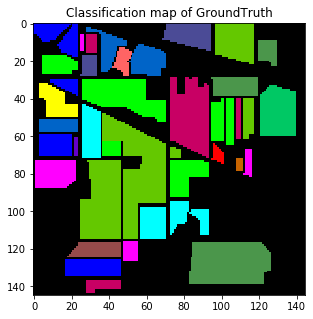

In [41]:
from matplotlib import pyplot as plt
# Plot the Ground Truth Image
ground_truth = spectral.imshow(classes = GroundTruth,figsize =(5,5))
plt.title('Classification map of GroundTruth')

Text(0.5, 1.0, 'Predicted Classification map by CNN')

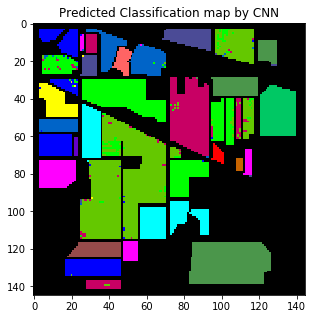

In [42]:
# Plot the Predicted image
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5),cmap= 'jet')
plt.title('Predicted Classification map by CNN')

In [43]:
from tqdm import tqdm
import pandas as pd
def extract_pixels(dataset, ground_truth):
    df = pd.DataFrame()
    for i in tqdm(range(dataset.shape[2])):
        df = pd.concat([df, pd.DataFrame(dataset[:, :, i].ravel())], axis=1)
    df = pd.concat([df, pd.DataFrame(ground_truth.ravel())], axis=1)
    df.columns = [f'band-{i}' for i in range(1, 1+dataset.shape[2])]+['class']
    return df

In [44]:
df = extract_pixels(Dataset,GroundTruth)

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 142.43it/s]


In [45]:
df.to_csv('Dataset.csv', index=False)

In [46]:
df = pd.read_csv('Dataset.csv')

In [47]:
df.head()

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-22,band-23,band-24,band-25,band-26,band-27,band-28,band-29,band-30,class
0,0.968768,0.480151,0.095013,0.125597,-0.835529,-0.153065,0.340916,-0.808385,0.739775,-0.196729,...,-0.684809,-0.735813,0.298723,0.712690,-0.504722,0.350504,-0.362198,-0.071948,-0.067022,3
1,1.082063,-0.666886,0.457615,-0.932147,0.283993,-0.641161,0.513250,0.639671,-1.369891,0.276042,...,-0.078364,0.645966,0.260609,-0.790352,-0.277622,1.125021,-0.488994,-1.698952,3.501347,3
2,1.119685,-1.018529,0.641121,-1.340924,0.498481,-0.292634,0.437311,0.546881,1.651550,-0.565766,...,0.059170,0.935491,0.692034,-1.017762,-0.928627,0.806780,0.205743,0.830251,0.072416,3
3,1.079131,-0.780896,0.465640,-0.886678,0.281052,-0.681895,0.634925,0.624049,-0.905910,0.162279,...,0.117354,0.684372,0.521070,-0.724930,-0.140018,1.183781,-0.596558,-1.623605,3.257161,3
4,0.969944,0.111926,-0.030070,-0.163259,-0.706674,-0.974477,1.271301,-0.917716,-0.543372,-0.199304,...,-0.240483,-0.181316,0.307950,0.055576,-0.221889,0.626910,-0.341948,0.375381,0.212688,3


In [48]:
df.tail()

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-22,band-23,band-24,band-25,band-26,band-27,band-28,band-29,band-30,class
21020,-1.446429,-0.595113,0.362794,0.393762,-0.140957,-0.115102,0.776806,-0.823795,-1.194214,0.297644,...,0.433514,-0.726573,1.548038,-0.736965,1.523312,-0.493800,1.268203,-0.175072,0.090765,0
21021,-1.496650,-0.603758,0.522121,0.160608,-0.764288,0.261460,0.927413,-0.550355,-0.718706,0.020027,...,1.878406,-2.435870,2.631545,-1.644268,0.863110,0.542319,2.327307,-0.069756,0.120433,0
21022,-1.423688,-0.373209,0.520396,0.166038,-0.689525,0.233609,0.910813,-0.402462,0.425064,0.019412,...,0.924966,-0.126389,0.662968,-0.339424,1.286519,-0.769500,0.667748,0.269178,-0.613299,0
21023,-1.255093,0.263083,0.884569,-0.347298,-1.470755,1.006944,0.644280,0.788674,0.618770,0.047798,...,1.553318,0.005729,-0.407840,0.526086,-1.209826,-0.072185,-0.177156,0.014728,-0.280383,0
21024,-1.269267,0.114281,0.608330,0.180292,-1.060265,0.590420,0.535895,0.771032,1.032087,-0.408936,...,0.624724,-2.124215,2.156621,-0.870835,-1.208511,0.551309,1.185802,0.511711,-0.542481,0


In [49]:
df.count()

band-1     21025
band-2     21025
band-3     21025
band-4     21025
band-5     21025
band-6     21025
band-7     21025
band-8     21025
band-9     21025
band-10    21025
band-11    21025
band-12    21025
band-13    21025
band-14    21025
band-15    21025
band-16    21025
band-17    21025
band-18    21025
band-19    21025
band-20    21025
band-21    21025
band-22    21025
band-23    21025
band-24    21025
band-25    21025
band-26    21025
band-27    21025
band-28    21025
band-29    21025
band-30    21025
class      21025
dtype: int64

In [50]:
Dataset = df.iloc[:, :-1].values

GroundTruth = df.iloc[:, -1].values

In [51]:
Dataset.shape, GroundTruth.shape

((21025, 30), (21025,))

In [52]:
from matplotlib import pyplot as plt

In [53]:
def plot_signature(df):
    plt.figure(figsize=(12, 6))
    pixel_no = np.random.randint(df.shape[0])
    plt.plot(range(1, 31), df.iloc[pixel_no, :-1].values.tolist(), 'b--', label= f'Class - {df.iloc[pixel_no, -1]}')
    plt.legend()
    plt.title(f'Pixel({pixel_no}) signature', fontsize=14)
    plt.xlabel('Band Number', fontsize=14)
    plt.ylabel('Pixel Intensity', fontsize=14)
    plt.show()

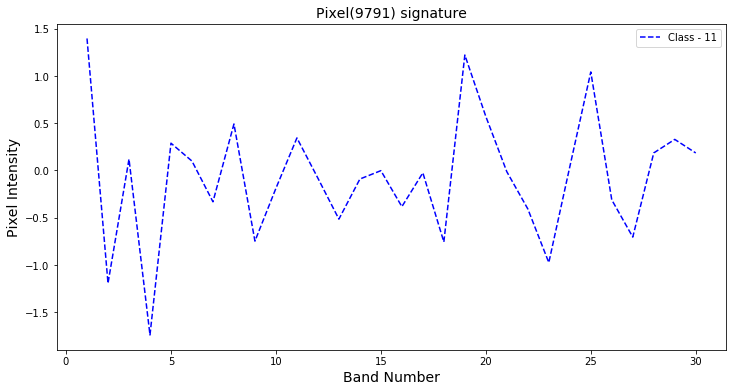

In [54]:
plot_signature(df)

In [55]:
print(f"Unique Class Labels: {df.loc[:, 'class'].unique()}")

Unique Class Labels: [ 3  0 15 11 12  5 10 14 16  2  4  8  6  9  1  7 13]


In [56]:
df.loc[:, 'class'].value_counts()

0     10776
11     2455
2      1428
14     1265
10      972
3       830
6       730
12      593
5       483
8       478
15      386
4       237
13      205
16       93
1        46
7        28
9        20
Name: class, dtype: int64

In [57]:
df[df['class']== 5][0:2000]

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-22,band-23,band-24,band-25,band-26,band-27,band-28,band-29,band-30,class
895,0.273131,1.470809,-1.185346,1.560744,0.759810,1.440026,2.328329,-0.497845,0.562169,-0.314895,...,-1.287825,-0.335817,-1.182549,-1.139125,-1.995377,-2.623156,1.800552,-0.912889,-0.387430,5
896,0.011583,0.801522,-1.600782,0.739374,1.434936,0.297444,2.881041,1.426291,-0.806027,0.894099,...,-0.454769,0.837700,-0.774804,-0.047282,0.896915,0.487413,0.278089,-0.150009,-0.231588,5
1040,0.298206,1.417528,-1.216626,1.532727,0.579674,1.717269,1.295921,0.062290,-0.376127,-0.687426,...,-1.933098,0.177724,0.017299,-1.273762,-2.375205,-2.127200,0.648991,-0.372330,-0.801953,5
1041,0.050617,0.891926,-1.611248,1.181963,0.938017,0.248575,3.485898,-0.344050,0.765643,-0.942539,...,-0.450614,0.334387,-0.126771,0.231083,-0.265827,0.072290,0.532932,0.376154,-0.113351,5
1185,0.410231,0.707526,-0.873147,0.408322,-0.405610,-0.847634,1.019140,-0.811418,-1.270860,-1.165404,...,-0.554486,0.118805,0.280525,0.508907,-0.255938,0.639407,0.417871,0.132434,0.027568,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18321,-0.175013,0.309561,-1.601250,-0.263922,1.579009,0.954831,1.361605,0.835528,0.564432,1.734105,...,-0.879529,1.664814,-0.015218,0.031175,-0.124134,0.848432,0.855601,0.653294,-0.656905,5
18322,-0.202043,0.286146,-1.604245,-0.251253,1.498047,0.995055,1.394744,0.934287,0.619594,1.653625,...,-0.648445,1.702321,-0.032141,0.105836,0.318531,0.973424,0.685857,0.644493,-0.742709,5
18323,-0.242639,0.339355,-1.749702,-0.134286,1.630332,0.780642,1.302802,0.892027,0.838005,2.380002,...,-0.153836,0.931980,0.500228,-0.460858,-1.126149,0.200709,-0.549643,1.231051,0.063523,5
18324,-0.256230,0.305667,-1.607788,-0.202424,1.698915,0.821338,1.284264,0.895452,1.723253,2.166642,...,-0.251538,0.752564,0.681028,-0.345569,-0.945532,0.239079,-0.130120,1.208851,-0.242470,5
